In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!which python

/home/hani/anaconda3/envs/pytorch/bin/python


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
exp_df = pd.read_csv('data/BRCA_SLAM_gs_TPM.selected.txt', sep="\t", index_col=0)
exp_df.head()

,HCC1806-PAR-1,HCC1806-PAR-2,MDA-PAR-1,MDA-PAR-2,MCF7-1,MCF7-2,MDA-MD-453-1,MDA-MD-453-2,HCC38-1,HCC38-2,ZR-75-1,ZR-75-2
GENE,,,,,,,,,,,,
A1BG,22.517513,22.553405,3.640235,3.655935,2.742338,2.464460,14.394453,19.079736,6.686106,9.582769,17.736295,13.347061
A1BG-AS1,1.259006,1.250263,0.008199,0.074092,0.103328,0.041350,0.322157,0.244604,0.415002,0.249507,0.078239,0.115105
A1CF,0.000000,0.000000,0.000000,0.003107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2M,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.790555,1.503693,0.120559,0.000000
A2ML1,0.034259,0.014818,0.000000,0.000000,0.005034,0.016621,0.000000,0.000000,0.000000,0.000000,0.006693,0.000000


In [5]:
#filter low expressing genes
exp_df = exp_df.loc[exp_df.sum(axis=1)>10,]
exp_df.shape

(12388, 12)

In [6]:
exp_df = np.log10(exp_df + 1e-6)
exp_df.head()

,HCC1806-PAR-1,HCC1806-PAR-2,MDA-PAR-1,MDA-PAR-2,MCF7-1,MCF7-2,MDA-MD-453-1,MDA-MD-453-2,HCC38-1,HCC38-2,ZR-75-1,ZR-75-2
GENE,,,,,,,,,,,,
A1BG,1.352520,1.353212,0.561130,0.562999,0.438121,0.391722,1.158195,1.280572,0.825173,0.981491,1.248863,1.125386
AAAS,0.044358,0.164927,-0.085645,0.240688,-0.012887,-0.054587,-0.066918,0.145048,0.192854,0.280589,0.208969,0.062319
AACS,0.534145,0.616855,0.526016,0.569601,0.758398,0.710714,0.553772,0.592084,0.680561,0.741635,0.840785,0.935845
AAED1,0.596877,0.662339,0.660540,0.688598,0.526909,0.441211,-0.068981,0.124260,0.355065,0.561544,0.290039,0.315982
AAGAB,0.623690,0.753050,0.475499,0.563754,0.956415,1.058104,1.041304,1.141294,0.740448,1.019033,1.213546,0.765552


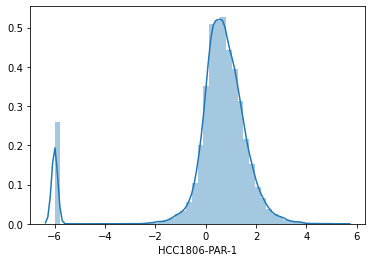

In [7]:
import seaborn as sns
sns.distplot(exp_df['HCC1806-PAR-1'])

In [8]:
RBPs = []
with open('data/GO_RNA_BINDING.txt', "rt") as file:
    file.readline()
    file.readline()
    for l in file:
        RBPs.append(l.rstrip())
RBPs = list(set(RBPs).intersection(set(exp_df.index.tolist())))
RBPs[:5]

['DNA2', 'RPL5', 'CNOT6', 'DIMT1', 'LRRC59']

In [9]:
len(RBPs)

1378

In [10]:
RBP_df = exp_df.loc[exp_df.index.isin(RBPs),]
RBP_df.head()

,HCC1806-PAR-1,HCC1806-PAR-2,MDA-PAR-1,MDA-PAR-2,MCF7-1,MCF7-2,MDA-MD-453-1,MDA-MD-453-2,HCC38-1,HCC38-2,ZR-75-1,ZR-75-2
GENE,,,,,,,,,,,,
AATF,2.117871,2.091740,2.142447,2.128862,1.432687,1.622653,1.527221,1.558252,1.944744,1.927603,1.593355,1.909840
ABCF1,2.077474,2.086078,2.088833,2.050634,1.834320,1.916774,1.740423,1.778803,2.052234,2.098287,1.922037,2.047142
ABT1,0.078380,0.235270,0.127963,0.163046,0.010476,0.013709,-0.137508,-0.131378,-0.009094,0.083754,0.010935,-0.510527
ACAA2,0.778147,0.806869,0.687299,0.759162,0.859164,0.830909,-0.800870,-1.079835,0.769112,0.801048,1.043748,0.944406
ACIN1,0.932024,0.941313,1.005578,1.051008,0.978527,0.814941,0.882527,0.821425,0.865873,0.912321,0.784165,1.006408


### Train RBP_VAE

In [11]:
trainX = RBP_df.T.to_numpy()
trainY = exp_df.T.to_numpy()
trainX.shape, trainY.shape

((12, 1378), (12, 12388))

In [22]:
from RBP_VAE import *

In [19]:
vae_data_loadter = DataLoader(vaeDataset(RBP_df.T.to_numpy(), exp_df.T.to_numpy()), batch_size=12, shuffle=True)

In [35]:
myVAE = VAE(trainX.shape[1], 50, trainY.shape[1])
print(myVAE)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=1378, out_features=500, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_mu): Linear(in_features=500, out_features=50, bias=True)
  (fc_var): Linear(in_features=500, out_features=50, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=500, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=500, out_features=12388, bias=True)
  )
)


In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
device

device(type='cuda')

In [37]:
myVAE.compile(device=device)

In [38]:
history = myVAE.train_model(vae_data_loadter, epochs=2000, device=device)

Train Epoch: 99 [0/128 (0%)]	Loss: 0.095445	Recon Loss: 0.070211	KL Loss: 0.488803
Train Epoch: 199 [0/128 (0%)]	Loss: 0.069273	Recon Loss: 0.039673	KL Loss: 0.443516
Train Epoch: 299 [0/128 (0%)]	Loss: 0.063836	Recon Loss: 0.035095	KL Loss: 0.375832
Train Epoch: 399 [0/128 (0%)]	Loss: 0.052935	Recon Loss: 0.023750	KL Loss: 0.348368
Train Epoch: 499 [0/128 (0%)]	Loss: 0.067224	Recon Loss: 0.037425	KL Loss: 0.332310
Train Epoch: 599 [0/128 (0%)]	Loss: 0.050729	Recon Loss: 0.019481	KL Loss: 0.330204
Train Epoch: 699 [0/128 (0%)]	Loss: 0.070363	Recon Loss: 0.033992	KL Loss: 0.367628
Train Epoch: 799 [0/128 (0%)]	Loss: 0.061124	Recon Loss: 0.027525	KL Loss: 0.327038
Train Epoch: 899 [0/128 (0%)]	Loss: 0.070729	Recon Loss: 0.034329	KL Loss: 0.342917
Train Epoch: 999 [0/128 (0%)]	Loss: 0.055740	Recon Loss: 0.014403	KL Loss: 0.378371
Train Epoch: 1099 [0/128 (0%)]	Loss: 0.066238	Recon Loss: 0.026918	KL Loss: 0.350785
Train Epoch: 1199 [0/128 (0%)]	Loss: 0.060507	Recon Loss: 0.019966	KL Loss: 

In [39]:
recon = myVAE(torch.from_numpy(trainX.astype(np.float32)).to(device))[0].to('cpu').detach().numpy()

In [40]:
from scipy.stats import pearsonr

Rs = []
for i in range(trainX.shape[0]):
    Rs.append(pearsonr(trainY[i,:], recon[i,:])[0])

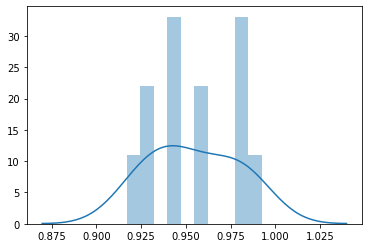

In [41]:
import seaborn as sns
sns.distplot(Rs, bins=10)

In [42]:
embed = myVAE(torch.from_numpy(trainX.astype(np.float32)).to(device))[1].to('cpu').detach().numpy()

In [43]:
import umap
trans = umap.UMAP(n_neighbors=5, random_state=42).fit(embed)

In [48]:
import re
umap_df = pd.DataFrame(list(zip(trans.embedding_[:, 0],
                                trans.embedding_[:, 1],
                                exp_df.columns,
                                [re.sub("-\d+$", "", x) for x in exp_df.columns])), columns =['UMAP1', 'UMAP2', 'id', 'cell'])
umap_df.head()

,UMAP1,UMAP2,id,cell
0,-2.073313,2.683848,HCC1806-PAR-1,HCC1806-PAR
1,-2.451240,2.160619,HCC1806-PAR-2,HCC1806-PAR
2,-3.000031,3.123960,MDA-PAR-1,MDA-PAR
3,-2.989351,2.436444,MDA-PAR-2,MDA-PAR
4,-2.791543,5.595730,MCF7-1,MCF7


/home/hani/anaconda3/envs/pytorch/lib/python3.6/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.



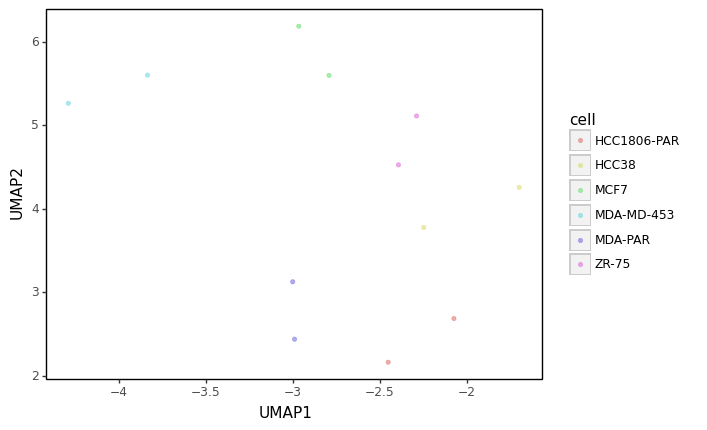

<ggplot: (8750896613794)>

In [49]:
from plotnine import *
plot = (ggplot(umap_df, aes(x="UMAP1", y="UMAP2", color="cell")) + geom_point(alpha=0.5, stroke = 0.25) +
    scale_colour_manual(values={True:"#FF3E3E", False:"#D5D5D5"})+ theme_bw(11) +
    scale_color_discrete() +
    theme(panel_background = element_rect(colour = "black",size=1), panel_grid_major = element_blank(),panel_grid_minor = element_blank()))
plot

In [51]:
torch.save(myVAE.state_dict(), 'models/model_VAE_50_latent.pt')

In [56]:
embed_df = pd.DataFrame(embed.T, columns=exp_df.columns)
embed_df.head()

,HCC1806-PAR-1,HCC1806-PAR-2,MDA-PAR-1,MDA-PAR-2,MCF7-1,MCF7-2,MDA-MD-453-1,MDA-MD-453-2,HCC38-1,HCC38-2,ZR-75-1,ZR-75-2
0,-0.513934,-0.013091,0.296917,0.204381,-0.076948,-0.208921,-0.088639,-0.152750,0.204965,-0.058599,0.281210,0.025269
1,0.074635,-0.009772,-0.222974,-0.120002,-0.076021,0.433860,-0.213282,0.130376,0.061653,0.013875,0.071214,-0.189190
2,0.028209,-0.140234,-0.058463,-0.198498,0.124454,0.031786,0.166356,0.364529,-0.190579,-0.110524,-0.166222,0.196372
3,0.087199,-0.125843,-0.249959,-0.332985,-0.007035,0.053864,0.034408,0.607286,0.239457,-0.119393,-0.060793,0.044186
4,0.105184,-0.311381,-0.361498,-0.276698,-0.317911,0.354223,0.078002,0.550400,0.095460,-0.098409,-0.049048,-0.011662


In [57]:
embed_df.to_csv("results/embed_df.txt", sep="\t")

In [62]:
RBP_df.to_csv("results/RBP_df.txt", sep="\t")

In [13]:
RBP_df = pd.read_csv("results/RBP_df.txt", sep="\t", index_col=0)
RBP_df.head()

,HCC1806-PAR-1,HCC1806-PAR-2,MDA-PAR-1,MDA-PAR-2,MCF7-1,MCF7-2,MDA-MD-453-1,MDA-MD-453-2,HCC38-1,HCC38-2,ZR-75-1,ZR-75-2
GENE,,,,,,,,,,,,
AATF,2.117871,2.091740,2.142447,2.128862,1.432687,1.622653,1.527221,1.558252,1.944744,1.927603,1.593355,1.909840
ABCF1,2.077474,2.086078,2.088833,2.050634,1.834320,1.916774,1.740423,1.778803,2.052234,2.098287,1.922037,2.047142
ABT1,0.078380,0.235270,0.127963,0.163046,0.010476,0.013709,-0.137508,-0.131378,-0.009094,0.083754,0.010935,-0.510527
ACAA2,0.778147,0.806869,0.687299,0.759162,0.859164,0.830909,-0.800870,-1.079835,0.769112,0.801048,1.043748,0.944406
ACIN1,0.932024,0.941313,1.005578,1.051008,0.978527,0.814941,0.882527,0.821425,0.865873,0.912321,0.784165,1.006408


### Prepare inputs

In [11]:
#convert the VAE embedding to a dictionary of lists
rbp_dict = {key:np.array(row.tolist()) for key,row in RBP_df.T.iterrows()}
list(rbp_dict.items())[:1]

[('HCC1806-PAR-1',
  array([2.11787066, 2.07747397, 0.0783796 , ..., 1.78853596, 1.16207628,
         0.109066  ]))]

In [ ]:
from Bio import SeqIO
import re
import gzip

lengths = []
with gzip.open('data/gencode.v28.major.iso.fa.gz', 'rt') as handle:
    for rec in SeqIO.parse(handle, "fasta"):
        if len(str(rec.seq))>max_len:
            max_len = len(str(rec.seq))
        lengths.append(len(str(rec.seq)))

In [81]:
np.percentile(lengths, q=range(1,100,5))

array([  88.  ,  127.  ,  244.  ,  314.  ,  393.  ,  450.  ,  504.14,
        559.  ,  603.  ,  676.24,  770.  ,  918.64, 1168.  , 1456.  ,
       1738.74, 2069.  , 2471.  , 3043.  , 3881.62, 5461.24])

In [12]:
from Bio import SeqIO
import re
import gzip

seq_dict = {}

count = 0
max_len = 4096-10
min_len = 512
with gzip.open('data/gencode.v28.major.iso.fa.gz', 'rt') as handle:
    for rec in SeqIO.parse(handle, "fasta"):
        if len(str(rec.seq))<=max_len and len(str(rec.seq))>=min_len:
            seq_dict[rec.id.split('|')[5]] = str(rec.seq)
            count += 1
count

6941

In [13]:
list(seq_dict.items())[:1]

[('RP5-857K21.8',
  'ATTAATCCCCTGGCCCAACCCGTCATCTACTCTACCATCTTTGCAGGCACACTCATCACAGCGCTAAGCTCGCACTGATTTTTTACCTGAGTAGGCCTAGAAATAAACATGCTAGCTTTTATTCCAGTTCTAACCAAAAAAATAAACCCTCGTTCCACAGAAGCTGCCATCAAGTATTTCCTCACGCAAGCAACCGCATCCATAATCCTTCTAATAGCTATCCTCTTCAACAATATACTCTCCGGACAATGAACCATAACCAATACCACCAATCAATACTCATCATTAATAATCATAATGGCTATAGCAATAAAACTAGGAATAGCCCCCTTTCACTTCTGAGTCCCAGAGGTTACCCAAGGCACCCCTCTGACATCCGGCCTGCTCCTTCTCACATGACAAAAACTAGCCCCCATCTCAATCATATACCAAATTTCTCCCTCATTAAACGTAAGCCTTCTCCTCACTCTTTCAATCTTATCCATCATGGCAGGCAGTTGAGGTGGATTAAACCAAACCCAACTACGCAAAATCTTAGCATACTCCTCAATTACCCACATAGGATGAATAACAGCAGTTCTACCGTACAACCCTAACATAACCATTCTTAATTTAACTATTTATATTATCCTAACTACTACCGCATTCCTACTACTCAACTTAAACTCCAGCACCACAACCCTACTACTATCTCGCACCTGAAACAAGCTAACATGACTAACACCCTTAATTCCATCCACCCTCCTCTCCCTAGGAGGCCTGCCCCCGCTAACCGGCTTTTTGCCCAAATGGGCCATTATCGAAGAATTCACAAAAAACAATAGCCTCATCATCCCCACCATCATAGCCATCATCACCCTCCTTAACCTCTACTTCTACCTGCGCCTAATCTACTCCACCTCAATCACACTACTCCCTATATCTAACAACGTAAAAATAAAATGACAGTTTGAACACACAAAACCCACCCCATTCCTCC

In [14]:
import re
decay_df = pd.read_csv('data/BRCA-lines_log10_decay_rates_gs.txt', sep="\t", index_col=0)
decay_df.columns = [re.sub("\.", "-", x) for x in decay_df.columns]
decay_df.head()

,HCC1806-PAR-1,HCC1806-PAR-2,MDA-PAR-1,MDA-PAR-2,MCF7-1,MCF7-2,MDA-MD-453-1,MDA-MD-453-2,HCC38-1,HCC38-2,ZR-75-1,ZR-75-2
A1BG,-1.066082,-1.280269,-0.285732,-0.639637,-0.326187,-0.664953,-0.719758,-0.812882,-1.439074,-0.731446,-1.717306,-1.054118
AACS,-0.125061,-0.058180,0.045117,-0.005526,-0.376835,-0.221019,0.063778,-0.058493,-0.308672,-0.569838,-0.351516,-0.318399
AAED1,-0.171404,-0.180253,0.074135,-0.004023,0.107655,0.336408,0.954444,0.670258,0.320970,-0.151047,0.191012,-0.197516
AAGAB,-0.400829,-0.165416,0.289347,-0.061730,-0.661292,-0.556470,-0.429905,-0.536963,-0.429548,-0.822612,-1.262680,-0.806532
AAK1,-1.045263,-0.947986,-0.742636,-0.721529,-0.451813,-0.670308,-0.605175,-0.498851,-0.723403,-0.852025,-0.914979,-0.630247


In [15]:
np.isinf(decay_df).values.sum()

0

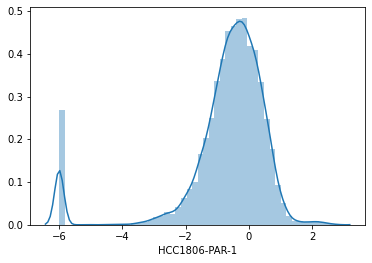

In [16]:
import matplotlib.pyplot as plt
sns.distplot(decay_df['HCC1806-PAR-1'])

In [17]:
decay_df_f = decay_df.loc[decay_df.index.isin(list(seq_dict.keys())),]
decay_df_f.shape

(6071, 12)

In [18]:
decay_df_long = decay_df_f.T.reset_index().melt(id_vars='index', value_vars=decay_df_f.index, var_name='gene', value_name='decay_rate')
decay_df_long['item'] = decay_df_long[['index','gene']].apply(lambda x: ','.join(x), axis=1)
decay_df_long.head()

,index,gene,decay_rate,item
0,HCC1806-PAR-1,AACS,-0.125061,"HCC1806-PAR-1,AACS"
1,HCC1806-PAR-2,AACS,-0.058180,"HCC1806-PAR-2,AACS"
2,MDA-PAR-1,AACS,0.045117,"MDA-PAR-1,AACS"
3,MDA-PAR-2,AACS,-0.005526,"MDA-PAR-2,AACS"
4,MCF7-1,AACS,-0.376835,"MCF7-1,AACS"


In [19]:
decay_dict = dict(zip(decay_df_long.item,decay_df_long.decay_rate))
dict(list(decay_dict.items())[0:5])

{'HCC1806-PAR-1,AACS': -0.125060728912093,
 'HCC1806-PAR-2,AACS': -0.0581799540332432,
 'MDA-PAR-1,AACS': 0.0451174448911943,
 'MDA-PAR-2,AACS': -0.00552580820037016,
 'MCF7-1,AACS': -0.376834991850856}

In [167]:
import pickle

with open('results/seq_dict.pkl', 'wb') as handle:
    pickle.dump(seq_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('results/decay_dict.pkl', 'wb') as handle:
    pickle.dump(decay_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('results/rbp_dict.pkl', 'wb') as handle:
    pickle.dump(rbp_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Train model

In [20]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
device

device(type='cuda')

In [24]:
import pickle

with open('results/seq_dict.pkl', 'rb') as handle:
    seq_dict = pickle.load(handle)
with open('results/decay_dict.pkl', 'rb') as handle:
    decay_dict = pickle.load(handle)
with open('results/rbp_dict.pkl', 'rb') as handle:
    rbp_dict = pickle.load(handle)

In [25]:
len(seq_dict.keys()), len(decay_dict.keys()), len(rbp_dict.keys())

(6941, 72852, 12)

In [26]:
from GreyHound import *

In [27]:
paired_list = np.array(list(decay_dict.keys()))
paired_list[:2]

array(['HCC1806-PAR-1,AACS', 'HCC1806-PAR-2,AACS'], dtype='<U33')

In [28]:
paired_list.shape

(72852,)

In [25]:
## Split the data between train and test
import random
import numpy as np
random.seed(0)

test_index = np.array(random.sample(range(paired_list.shape[0]), int(paired_list.shape[0]*0.15)))
mask = np.zeros(len(paired_list),dtype=bool)
mask[test_index] = True

paired_list_test = paired_list[mask]
tmp_list = paired_list[~mask]

valid_index = np.array(random.sample(range(tmp_list.shape[0]), int(tmp_list.shape[0]*0.05)))
mask = np.zeros(len(tmp_list),dtype=bool)
mask[valid_index] = True

paired_list_valid = tmp_list[mask]
paired_list_train = tmp_list[~mask]

print(len(paired_list_train), len(paired_list_valid), len(paired_list_test))
paired_list_valid[:5]

58829 3096 10927


array(['MDA-PAR-1,AAR2', 'HCC38-2,AASDH', 'MCF7-2,ABCD3',
       'HCC38-1,ABHD11', 'HCC38-2,ABHD14A'], dtype='<U33')

In [26]:
import pickle

with open('results/paired_list_test.pkl', 'wb') as handle:
    pickle.dump(paired_list_test, handle)
with open('results/paired_list_valid.pkl', 'wb') as handle:
    pickle.dump(paired_list_valid, handle)
with open('results/paired_list_train.pkl', 'wb') as handle:
    pickle.dump(paired_list_train, handle)

In [29]:
import pickle

with open('results/paired_list_test.pkl', 'rb') as handle:
    paired_list_test = pickle.load(handle)
with open('results/paired_list_valid.pkl', 'rb') as handle:
    paired_list_valid = pickle.load(handle)
with open('results/paired_list_train.pkl', 'rb') as handle:
    paired_list_train = pickle.load(handle)

In [30]:
seq_length=4096

In [23]:
train_data_loader = DataLoader(GHDataset(paired_list_train, decay_dict, seq_dict, rbp_dict, max_len=seq_length), batch_size=32, shuffle=True, drop_last=True)
valid_data_loader = DataLoader(GHDataset(paired_list_valid, decay_dict, seq_dict, rbp_dict, max_len=seq_length), batch_size=32, shuffle=False, drop_last=False)

In [24]:
tseq, tenc, texp = next(iter(train_data_loader))
tseq.shape, tenc.shape, texp.shape

(torch.Size([32, 4, 4096]), torch.Size([32, 1378]), torch.Size([32, 1]))

In [31]:
from GreyHound import *
model = GreyHoundModel(max_len=seq_length)
print(model)

GreyHoundModel(
  (conv_block_1): Sequential(
    (0): Conv1d(4, 64, kernel_size=(10,), stride=(1,), padding=(10,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=10, stride=5, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=(5,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (dilations): ModuleList(
    (0): Sequential(
      (0): Conv1d(32, 4, kernel_size=(3,), stride=(1,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0)

In [32]:
from RBP_VAE import *
myVAE = VAE(1378, 50, 12388)
myVAE.load_model('models/model_VAE_50_latent.pt')

In [33]:
model.transfer_vae(myVAE)

In [34]:
model.compile(device=device)

In [184]:
logfile = open('models/history.log', 'wt', buffering=1)

In [185]:
hist = model.train_model(train_data_loader,val_loader=valid_data_loader, epochs=10, device=device, logfile=logfile)

Train Epoch: 0 [0/58829 (0%)]	Loss: 1.399896	R: 0.276482
Train Epoch: 0 [320/58829 (1%)]	Loss: 0.976859	R: 0.195284
Train Epoch: 0 [640/58829 (1%)]	Loss: 0.622522	R: 0.319608
Train Epoch: 0 [960/58829 (2%)]	Loss: 0.783669	R: 0.409279
Train Epoch: 0 [1280/58829 (2%)]	Loss: 0.797140	R: 0.296849
Train Epoch: 0 [1600/58829 (3%)]	Loss: 1.512855	R: 0.501740
Train Epoch: 0 [1920/58829 (3%)]	Loss: 0.506010	R: 0.234265
Train Epoch: 0 [2240/58829 (4%)]	Loss: 0.936124	R: 0.051606
Train Epoch: 0 [2560/58829 (4%)]	Loss: 1.418646	R: 0.088704
Train Epoch: 0 [2880/58829 (5%)]	Loss: 0.723489	R: 0.140631
Train Epoch: 0 [3200/58829 (5%)]	Loss: 0.432630	R: 0.128244
Train Epoch: 0 [3520/58829 (6%)]	Loss: 0.458403	R: 0.251737
Train Epoch: 0 [3840/58829 (7%)]	Loss: 1.154619	R: 0.045495
Train Epoch: 0 [4160/58829 (7%)]	Loss: 0.801415	R: 0.323143
Train Epoch: 0 [4480/58829 (8%)]	Loss: 0.734940	R: 0.221564
Train Epoch: 0 [4800/58829 (8%)]	Loss: 0.575310	R: 0.369228
Train Epoch: 0 [5120/58829 (9%)]	Loss: 0.32301

In [186]:
model.make_trainable()

In [187]:
hist2 = model.train_model(train_data_loader,val_loader=valid_data_loader, epochs=5, device=device, logfile=logfile)

Train Epoch: 0 [0/58829 (0%)]	Loss: 0.347883	R: 0.597218
Train Epoch: 0 [320/58829 (1%)]	Loss: 0.792508	R: 0.570031
Train Epoch: 0 [640/58829 (1%)]	Loss: 1.267023	R: 0.252817
Train Epoch: 0 [960/58829 (2%)]	Loss: 1.047438	R: 0.688190
Train Epoch: 0 [1280/58829 (2%)]	Loss: 1.178609	R: 0.533514
Train Epoch: 0 [1600/58829 (3%)]	Loss: 0.341664	R: 0.621005
Train Epoch: 0 [1920/58829 (3%)]	Loss: 0.263584	R: 0.648135
Train Epoch: 0 [2240/58829 (4%)]	Loss: 0.380534	R: 0.572607
Train Epoch: 0 [2560/58829 (4%)]	Loss: 0.362142	R: 0.698806
Train Epoch: 0 [2880/58829 (5%)]	Loss: 0.474156	R: 0.653404
Train Epoch: 0 [3200/58829 (5%)]	Loss: 1.098200	R: 0.491482
Train Epoch: 0 [3520/58829 (6%)]	Loss: 1.468256	R: 0.310023
Train Epoch: 0 [3840/58829 (7%)]	Loss: 1.244123	R: 0.433663
Train Epoch: 0 [4160/58829 (7%)]	Loss: 0.702768	R: 0.299223
Train Epoch: 0 [4480/58829 (8%)]	Loss: 0.628988	R: 0.323006
Train Epoch: 0 [4800/58829 (8%)]	Loss: 0.317175	R: 0.475369
Train Epoch: 0 [5120/58829 (9%)]	Loss: 1.26122

In [188]:
model.save_model('models/GH_default_R0.62.pt')

In [35]:
model.load_model('models/GH_default_R0.62.pt')

In [33]:
test_data_loader = DataLoader(GHDataset(paired_list_test, decay_dict, seq_dict, rbp_dict, max_len=seq_length), batch_size=32, shuffle=False, drop_last=False)

In [28]:
model.to(device)

GreyHoundModel(
  (conv_block_1): Sequential(
    (0): Conv1d(4, 64, kernel_size=(10,), stride=(1,), padding=(10,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=10, stride=5, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=(5,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (dilations): ModuleList(
    (0): Sequential(
      (0): Conv1d(32, 4, kernel_size=(3,), stride=(1,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0)

In [35]:
model.eval()
target_list = []
pred_list = []
seq_id_list = []
with torch.no_grad():
    for batch_idx, batch in enumerate(test_data_loader):
        seq_X, rbp_X, y = batch
        seq_X = seq_X.to(device)
        rbp_X = rbp_X.to(device)
        y = y.to(device)
        out = model(seq_X, rbp_X)
        pred_list.append(out[:,0].to('cpu').detach().numpy())
        target_list.append(y.to('cpu').detach().numpy())
    targets = np.concatenate(target_list)
    preds = np.concatenate(pred_list)

In [36]:
import scipy.stats as stats
stats.pearsonr(targets[:,0], preds)

(0.6242937506251979, 0.0)

In [37]:
test_df = pd.DataFrame(zip(targets[:,0], preds))
test_df.columns = ['targets', 'preds']
test_df.index = paired_list_test
test_df.head()

,targets,preds
"MDA-PAR-2,AACS",-0.005526,-0.250512
"HCC38-2,AACS",-0.569838,-0.423888
"MDA-PAR-1,AAED1",0.074135,0.141496
"MCF7-2,AAED1",0.336408,0.168224
"HCC38-2,AAED1",-0.151047,-0.002698


In [38]:
test_df.to_hdf('results/test_pred.df.h5', key='data')

In [39]:
r,pv = stats.pearsonr(test_df.targets, test_df.preds)
r,pv

(0.6242937506251979, 0.0)

/home/hani/anaconda3/envs/pytorch/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3 x 3 in image.
/home/hani/anaconda3/envs/pytorch/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: model_test_performamce.pdf
/home/hani/anaconda3/envs/pytorch/lib/python3.6/site-packages/plotnine/layer.py:464: PlotnineWarning: geom_point : Removed 126 rows containing missing values.
/home/hani/anaconda3/envs/pytorch/lib/python3.6/site-packages/plotnine/layer.py:464: PlotnineWarning: geom_point : Removed 126 rows containing missing values.


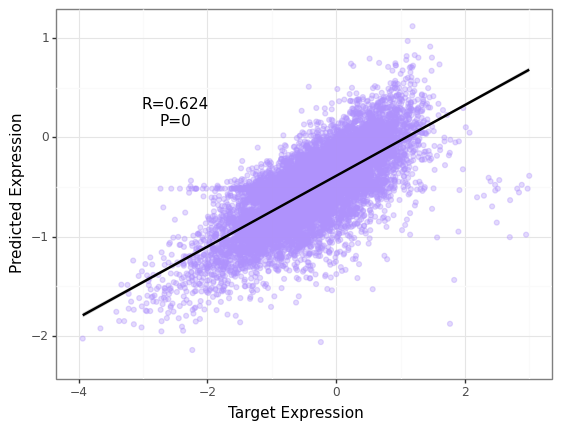

<ggplot: (8747019125410)>

In [40]:
from plotnine import *
plot = (
    ggplot(test_df, aes(x='targets', y='preds')) +
    geom_point(alpha=0.35, color="#AF92FC") +
    geom_smooth(method="lm",se=True,size=1) +
    xlab("Target Expression") +
    ylab("Predicted Expression") +
    xlim([-4,3]) +
    annotate("text", x=-2.5,y=0.25, label="R={0:.3f}\nP={1:.3g}".format(r,pv))+
    theme_bw(11)
)
plot.save('model_test_performamce.pdf', width=3, height=3)
plot

In [201]:
all_data_loader = DataLoader(GHDataset(paired_list, decay_dict, seq_dict, rbp_dict, max_len=seq_length), batch_size=32, shuffle=False, drop_last=False)

In [202]:
model.eval()
target_list = []
pred_list = []
seq_id_list = []
with torch.no_grad():
    for batch_idx, batch in enumerate(all_data_loader):
        seq_X, rbp_X, y = batch
        seq_X = seq_X.to(device)
        rbp_X = rbp_X.to(device)
        y = y.to(device)
        out = model(seq_X, rbp_X)
        pred_list.append(out[:,0].to('cpu').detach().numpy())
        target_list.append(y.to('cpu').detach().numpy())
    targets = np.concatenate(target_list)
    preds = np.concatenate(pred_list)

In [203]:
all_df = pd.DataFrame(zip(targets[:,0], preds))
all_df.columns = ['targets', 'preds']
all_df.index = paired_list
all_df.head()

,targets,preds
"HCC1806-PAR-1,AACS",-0.125061,-0.392189
"HCC1806-PAR-2,AACS",-0.058180,-0.388799
"MDA-PAR-1,AACS",0.045117,-0.224802
"MDA-PAR-2,AACS",-0.005526,-0.360382
"MCF7-1,AACS",-0.376835,-0.362800


/home/hani/anaconda3/envs/pytorch/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3 x 3 in image.
/home/hani/anaconda3/envs/pytorch/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: model_all_performamce.pdf
/home/hani/anaconda3/envs/pytorch/lib/python3.6/site-packages/plotnine/layer.py:464: PlotnineWarning: geom_point : Removed 776 rows containing missing values.
/home/hani/anaconda3/envs/pytorch/lib/python3.6/site-packages/plotnine/layer.py:464: PlotnineWarning: geom_point : Removed 776 rows containing missing values.


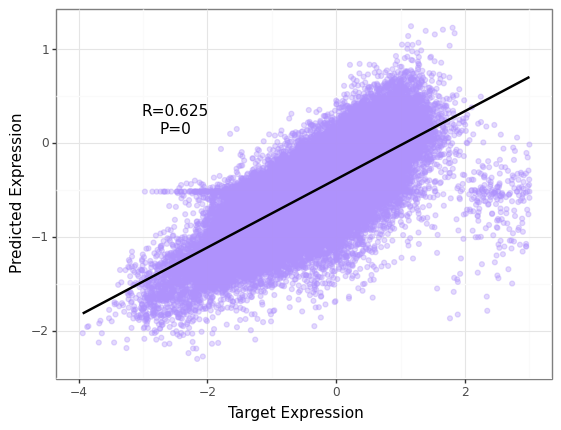

<ggplot: (-9223363272881555740)>

In [207]:
from plotnine import *
plot = (
    ggplot(all_df, aes(x='targets', y='preds')) +
    geom_point(alpha=0.35, color="#AF92FC") +
    geom_smooth(method="lm",se=True,size=1) +
    xlab("Target Expression") +
    ylab("Predicted Expression") +
    xlim([-4,3]) +
    annotate("text", x=-2.5,y=0.25, label="R={0:.3f}\nP={1:.3g}".format(r,pv))+
    theme_bw(11)
)
plot.save('model_all_performamce.pdf', width=3, height=3)
plot

In [208]:
all_df.to_csv('results/all_pred.df.csv', sep="\t")

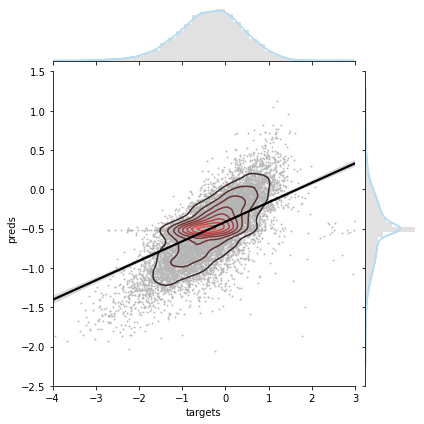

In [209]:
g = sns.jointplot(data=test_df, x="targets", y="preds", kind="reg", xlim=(-4, 3), ylim=(-2.5, 1.5), color='#B5B5B5', scatter_kws={'s': 1, 'rasterized':True}, joint_kws = {'scatter_kws':dict(alpha=0.5)}, line_kws={'color': 'black'})
g.plot_joint(sns.kdeplot, color="#FF5252", levels=10)
g.plot_marginals(sns.kdeplot, color="#AEE4FF")

In [210]:
g.savefig('GH_all_corrplot.pdf', dpi=300)

## Saliency scores

In [52]:
device='cpu'
model = model.to(device)

In [86]:
from scipy.stats import variation
from scipy.signal import find_peaks
from skmisc.loess import loess
from scipy.signal import savgol_filter

samples = exp_df.columns.to_list()
def extract_seq_from_importance(gene, model, fastafile, rbpfile, rangefile):
    print(gene)
    model.eval()
    model.requires_grad = True
    tmp_pair = [
        f"{samp},{gene}" for samp in samples if f"{samp},{gene}" in decay_dict
    ]
    #if len(tmp_pair)<5:
    #    return {'gene':gene, 'seqs':[], 'peaks':[], 'rbp':[]}

    data_loader = DataLoader(GHDataset(tmp_pair, decay_dict, seq_dict, rbp_dict, max_len=seq_length, left_pad_max=0), batch_size=len(tmp_pair), shuffle=False, drop_last=False)

    seq_X, rbp_X, y = next(iter(data_loader))
    seq_X.requires_grad = True
    rbp_X.requires_grad = True
    seq_X = seq_X.to(device)
    rbp_X = rbp_X.to(device)
    y = y.to(device)
    out = model(seq_X, rbp_X)

    loss = model.loss_fn(out,y)
    loss.backward()

    ## find salient sequences with highly variable scores across the lines
    seq_S = seq_X * seq_X.grad
    seq_S = seq_S.sum(axis=1)
    seq_S = np.abs(seq_S.detach().numpy())

    mu = seq_S.mean(axis=0)
    var = seq_S.std(axis=0)
    
    if (mu.sum()==0.0):
        return

    not_const = var > 0
    estimat_var = np.zeros(mu.shape[0], dtype=np.float64)
    y = var[not_const]
    x = mu[not_const]
    loess_model = loess(x, y, degree=2, surface='direct')
    loess_model.fit()
    estimat_var[not_const] = loess_model.outputs.fitted_values
    signal = var - estimat_var
    signal[signal<0] = 0

    cv = np.zeros(mu.shape[0], dtype=np.float64)
    cv[signal>0] = np.sqrt(var[signal>0]) / np.abs(mu[signal>0])
    cv = savgol_filter(cv, 11, 3)
    th = np.percentile(cv, 90)
    cv[cv<th] = 0

    peaks, _ = find_peaks(cv)
    #merge overlapping peaks
    prange = [(peak-10,peak+10) for peak in peaks]
    prange_union = []
    for begin,end in sorted(prange):
        if prange_union and prange_union[-1][1] >= begin - 1:
            prange_union[-1][1] = max(prange_union[-1][1], end)
        else:
            prange_union.append([begin, end])

    #extract sequences
    seqs = [seq_dict[gene][max(0,a):min(seq_length,b)] for a,b in prange_union]

    ## RBP scores
    ## find salient RBPs with highly variable scores across the lines
    rbp_S = rbp_X * rbp_X.grad
    rbp_S = np.abs(rbp_S.detach().numpy())
    mu = rbp_S.mean(axis=0)
    var = rbp_S.std(axis=0)
    not_const = var > 0
    estimat_var = np.zeros(mu.shape[0], dtype=np.float64)
    y = var[not_const]
    x = mu[not_const]
    loess_model = loess(x, y, degree=2, surface='direct')
    loess_model.fit()
    estimat_var[not_const] = loess_model.outputs.fitted_values
    signal = var - estimat_var
    signal[signal<0] = 0

    cv = np.zeros(mu.shape[0], dtype=np.float64)
    cv[signal>0] = np.sqrt(var[signal>0]) / np.abs(mu[signal>0])
    #cv = savgol_filter(cv, 11, 3)
    th = np.percentile(cv, 90)
    cv[cv<th] = 0
    rbp_scores = cv
    
    for i,s in enumerate(seqs):
        fastafile.write(f">{gene}.{i}\n{s}\n")
    for i,s in enumerate(seqs):
        rangefile.write(f">{gene}.{i}\n{prange_union[i]}\n")
    rbpfile.write(f"{gene}\t"+"\t".join([str(x) for x in rbp_scores])+"\n")
    fastafile.flush()
    rangefile.flush()
    rbpfile.flush()
    return {'gene':gene, 'seqs':seqs, 'peaks':prange_union, 'rbp':rbp_scores}

In [87]:
fastafile = open("results/salient_seqs.fa", "wt")
rangefile = open("results/salient_ranges.txt", "wt")
rbpfile = open("results/salient_rbps.txt", "wt")
rbpfile.write("\t"+"\t".join(RBP_df.T.columns)+"\n")

8544

In [89]:
fastafile.close()
rangefile.close()
rbpfile.close()

In [ ]:
!python /rasis/Projects/bin/TEISERv1.1/prep_fasta_for_fire_run.py results/salient_seqs.fa

In [ ]:
%%bash
cd results
perl $FIREDIR/fire.pl --expfile=salient_seqs_fire.txt --fastafile_rna=salient_seqs_fire.fa --species=human \
--exptype=discrete --nodups=1 --oribiasonly=0  --dodna=0 --dodnarna=0

In [616]:
rbp_sal_df = pd.DataFrame.from_dict(rbp_sal_dict, orient='index')
rbp_sal_df.columns = RBP_df.T.columns
#rbp_sal_df[rbp_sal_df>0] = 1
rbp_sal_df.head()

GENE,AATF,ABCF1,ABT1,ACAA2,ACIN1,ACO1,ACTN1,ACTN4,ADAR,ADARB1,...,ZNF326,ZNF346,ZNF598,ZNF622,ZNF638,ZNF768,ZNFX1,ZRANB2,ZRSR2,ZYX
AACS,0.0,340.124798,449.896911,479.957684,449.216124,376.581237,303.584703,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAED1,0.0,0.000000,421.978603,468.631196,434.133978,345.385132,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGAB,0.0,0.000000,218.316997,215.281027,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAMP,0.0,215.109368,285.572485,275.318944,211.234975,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAR2,0.0,162.626488,215.071265,208.093978,161.497136,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


From the RBP encoder module, extarct the saliency DF for RBPs that are annotated as mRNA binding

In [628]:
rbp_sal_df.mean().sort_values(ascending=False)

GENE
FNDC3A    383.744399
FNDC3B    358.855510
RPP14     352.501224
FMR1      345.470880
SYNJ2     339.260758
             ...    
SRP68       0.000000
SRP54       0.000000
MRPL21      0.000000
MRPL20      0.000000
STRAP       0.000000
Length: 1378, dtype: float64

In [637]:
rbp_sal_score_dict = rbp_sal_df.mean().to_dict()
list(rbp_sal_score_dict.items())[:5]

[('AATF', 0.5827859476576321),
 ('ABCF1', 109.19390735796392),
 ('ABT1', 269.15321594874735),
 ('ACAA2', 288.19496593160073),
 ('ACIN1', 220.36387112115273)]

In [638]:
RBPs = []
with open('data/GOMF_MRNA_BINDING.txt', "rt") as file:
    file.readline()
    file.readline()
    for l in file:
        RBPs.append(l.rstrip())
RBPs = list(set(RBPs).intersection(set(exp_df.index.tolist())))
RBPs[:5]

['YTHDF1', 'MEX3D', 'IGF2BP3', 'MT-TS1', 'RPL5']

In [642]:
rbp_sal_score_dict['RBMS3']

45.848060204682575

In [654]:
salient_RBPs = [rbp for rbp in rbp_sal_df.mean()[rbp_sal_df.mean()>rbp_sal_df.mean().quantile(0.74)].index if rbp in RBPs]
salient_RBPs[:5]

['ACO1', 'AGO2', 'CPSF6', 'CRYZ', 'CSTF2']

In [655]:
len(salient_RBPs)

59

### Generate motif vs RBP saliency maps

In [656]:
motifs = pd.read_csv('results/salient_seqs_fire.txt_FIRE/RNA/salient_seqs_fire.txt.summary', sep="\t", header=None)[0].to_list()
motifs

['[CT][AG]CCTGTA.',
 '.[AGT][AT]ATA[AT]A.',
 'CC[AG][CT]C[AGT]CC.',
 '[CGT]CTAC[GT][AT]C.',
 '.CTACAGC.',
 '.C[AG]AGTAC.']

In [657]:
motifs_rna = [re.sub("\.", "N", x) for x in motifs]
motifs_rna = [re.sub("T", "U", x) for x in motifs_rna]
motifs_rna

['[CU][AG]CCUGUAN',
 'N[AGU][AU]AUA[AU]AN',
 'CC[AG][CU]C[AGU]CCN',
 '[CGU]CUAC[GU][AU]CN',
 'NCUACAGCN',
 'NC[AG]AGUACN']

In [660]:
import os

cmd = "iupac2meme -alph results/RNAalphabet.txt \"" + "\" \"".join(motifs_rna) + "\" > results/motifs_rna.meme"
print(cmd)
os.system(cmd)

iupac2meme -alph results/RNAalphabet.txt "[CU][AG]CCUGUAN" "N[AGU][AU]AUA[AU]AN" "CC[AG][CU]C[AGU]CCN" "[CGU]CUAC[GU][AU]CN" "NCUACAGCN" "NC[AG]AGUACN" > results/motifs_rna.meme


32512

In [658]:
!head results/motifs_rna.meme

MEME version 4

ALPHABET "ACGU"

Background letter frequencies (from uniform background):
A 0.25000 C 0.25000 G 0.25000 U 0.25000 

MOTIF CC[AG][CU]C[AGU]CCN 

letter-probability matrix: alength= 4 w= 9 nsites= 20 E= 0


In [586]:
os.system("tomtom -o results/motifs_rna_meme_match -eps results/motifs_rna.meme /rasis/Projects/bin/meme/motif_databases/RNA/Ray2013_rbp_Homo_sapiens.meme")

32512

In [661]:
!cat results/motifs_rna_meme_match/tomtom.txt

#Query ID	Target ID	Optimal offset	p-value	E-value	q-value	Overlap	Query consensus	Target consensus	Orientation
CC[AG][CU]C[AGU]CCN	RNCMPT00186	-1	0.00323999	0.330479	0.193846	7	CCACCUCCA	CCUUUCC	+
CC[AG][CU]C[AGU]CCN	RNCMPT00044	0	0.00494413	0.504301	0.193846	7	CCACCUCCA	CCUUCCC	+
CC[AG][CU]C[AGU]CCN	RNCMPT00026	0	0.00690887	0.704705	0.193846	7	CCACCUCCA	CCAACCC	+
CC[AG][CU]C[AGU]CCN	RNCMPT00116	1	0.00787376	0.803124	0.193846	6	CCACCUCCA	AACAUCA	+
CC[AG][CU]C[AGU]CCN	RNCMPT00083	1	0.0140077	1.42879	0.275888	6	CCACCUCCA	AACAUCA	+
NCUACAGCN	RNCMPT00084	-2	0.00708604	0.722776	0.298962	7	ACUACAGCA	AACAACA	+
NCUACAGCN	RNCMPT00149	0	0.00789274	0.80506	0.298962	7	ACUACAGCA	CAGACAG	+
NCUACAGCN	RNCMPT00156	-2	0.010903	1.11211	0.298962	7	ACUACAGCA	GACAGAU	+
NCUACAGCN	RNCMPT00083	-2	0.0135223	1.37927	0.298962	7	ACUACAGCA	AACAUCA	+
NCUACAGCN	RNCMPT00116	-2	0.0186187	1.89911	0.32931	7	ACUACAGCA	AACAUCA	+
NCUACAGCN	RNCMPT00170	0	0.0341987	3.48827	0.475219	7	ACUACAGCA	AAUCCAG	+
NCUACAGCN	RNCMPT00053

To create an RBP motif-map, we will take genes for which the RBP of interest was salient. We will then output the salient sequences for these genes, along with shuffled sequences as control. Then use FIRE innon-discovery mode to calculate enrichment stats for the motifs.

In [668]:
import ushuffle

In [669]:
!mkdir results/salient_rbp_profiles

In [679]:
salient_obj_dict = defaultdict(list)
for item in salient_obj:
    if item:
        salient_obj_dict[item['gene']] = item['seqs']

In [687]:
for rbp in salient_RBPs:
    genes = rbp_sal_df.index[rbp_sal_df[rbp]>0].to_list()
    with open(f"results/salient_rbp_profiles/salient_{rbp}_seqs.fa", "wt") as fa, open(f"results/salient_rbp_profiles/salient_{rbp}_seqs.txt", "wt") as pro:
        pro.write("gene\tvalue\n")
        for gene in genes:
            if gene in salient_obj_dict:
                seqs = salient_obj_dict[gene]
                fa.write(f">{gene}\n")
                pro.write(f"{gene}\t1\n")
                for seq in seqs:
                    fa.write(f"{seq}NNNNNNNNNNNNNNNN")
                fa.write("\n")
                fa.write(f">{gene}_shuf\n")
                pro.write(f"{gene}_shuf\t0\n")
                for seq in seqs:
                    n_seq = ushuffle.shuffle(seq, len(seq), 2)
                    fa.write(f"{n_seq}NNNNNNNNNNNNNNNN")
                fa.write("\n")

In [ ]:
for rbp in salient_RBPs:
    cmd = (f"perl /rasis/Projects/bin/FIRE-1.1/fire.pl --expfile=results/salient_rbp_profiles/salient_{rbp}_seqs.txt "
           f"--fastafile_rna=results/salient_rbp_profiles/salient_{rbp}_seqs.fa --species=human "
           "--doskipdiscovery=1 --motiffile_rna=results/FIRE_dicovery_poscor.motifs "
           "--exptype=discrete --nodups=1 --oribiasonly=0  --dodna=0 --dodnarna=0")
    print(cmd)
    os.system(cmd)

In [732]:
import glob
import re
from collections import defaultdict

rbp_seq_hyper_dict = defaultdict(dict)
for file in glob.glob("results/salient_rbp_profiles/salient_*_seqs.txt_FIRE/RNA/*.matrix"):
    rbp = re.sub("results/salient_rbp_profiles/salient_(\S+)_seqs.txt_FIRE/RNA/\S+.matrix", "\\1", file)
    hpv = pd.read_csv(file, sep="\t", index_col=0)['C1'].to_dict()
    rbp_seq_hyper_dict[rbp] = {x:hpv[x] for x in hpv}

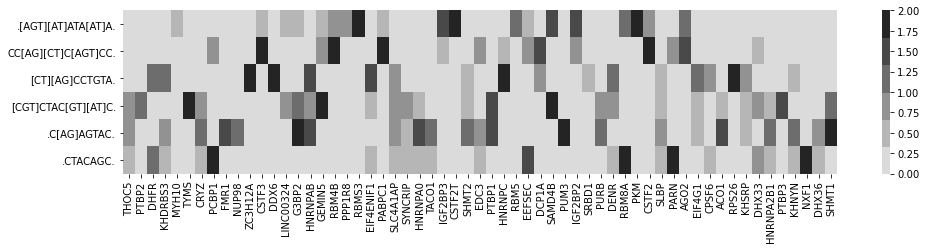

In [760]:
fig, ax = plt.subplots(figsize=(16,3))
rbp_seq_hyper_df = pd.DataFrame.from_dict(rbp_seq_hyper_dict).fillna(0.1)
rbp_seq_hyper_df.to_csv('results/rbp_motifs_int_map_df.txt', sep="\t")
rbp_seq_hyper_df = rbp_seq_hyper_df.apply(lambda x: x/x.mean(), axis=0)
rbp_seq_hyper_df = rbp_seq_hyper_df.apply(lambda x: (x-x.mean())/x.std(), axis=1)
rbp_seq_hyper_df.to_csv('results/rbp_motifs_int_map_df_norm.txt', sep="\t")
rbp_seq_hyper_df[rbp_seq_hyper_df<0] = 0
sns.heatmap(rbp_seq_hyper_df, vmin=0, vmax=2, cmap=sns.color_palette("gray_r"))
plt.savefig("results/rbp_motifs_int_map_df_norm.pdf") 

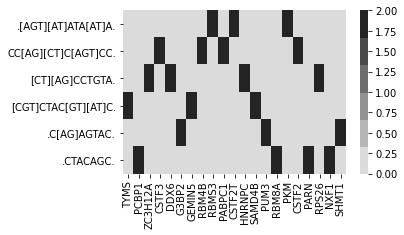

In [761]:
fig, ax = plt.subplots(figsize=(5,3))
rbp_seq_hyper_df[rbp_seq_hyper_df<1.69] = 0
rbp_seq_hyper_df = rbp_seq_hyper_df.loc[:,rbp_seq_hyper_df.sum()>0]
rbp_seq_hyper_df.to_csv('results/rbp_motifs_int_map_df_norm_cut.txt', sep="\t")
sns.heatmap(rbp_seq_hyper_df, vmin=0, vmax=2, cmap=sns.color_palette("gray_r"))
plt.savefig("results/rbp_motifs_int_map_df_norm_cut.pdf") 

In [764]:
rbp_seq_hyper_df[rbp_seq_hyper_df>=1.69] = 1

In [768]:
rbp_seq_hyper_df_long = rbp_seq_hyper_df.reset_index().melt(id_vars='index', value_vars=rbp_seq_hyper_df.columns, var_name='RBP', value_name='edge').query("edge==1")
rbp_seq_hyper_df_long.columns = ['motif', 'RBP', 'edge']
rbp_seq_hyper_df_long.head()

,motif,RBP,edge
3,[CGT]CTAC[GT][AT]C.,TYMS,1.0
11,.CTACAGC.,PCBP1,1.0
14,[CT][AG]CCTGTA.,ZC3H12A,1.0
19,CC[AG][CT]C[AGT]CC.,CSTF3,1.0
26,[CT][AG]CCTGTA.,DDX6,1.0


Use RBP-motif hits from the saliency maps to find those that are correlated with the stability of the regulon

In [769]:
decay_df.head()

,HCC1806-PAR-1,HCC1806-PAR-2,MDA-PAR-1,MDA-PAR-2,MCF7-1,MCF7-2,MDA-MD-453-1,MDA-MD-453-2,HCC38-1,HCC38-2,ZR-75-1,ZR-75-2
A1BG,-1.066082,-1.280269,-0.285732,-0.639637,-0.326187,-0.664953,-0.719758,-0.812882,-1.439074,-0.731446,-1.717306,-1.054118
AACS,-0.125061,-0.058180,0.045117,-0.005526,-0.376835,-0.221019,0.063778,-0.058493,-0.308672,-0.569838,-0.351516,-0.318399
AAED1,-0.171404,-0.180253,0.074135,-0.004023,0.107655,0.336408,0.954444,0.670258,0.320970,-0.151047,0.191012,-0.197516
AAGAB,-0.400829,-0.165416,0.289347,-0.061730,-0.661292,-0.556470,-0.429905,-0.536963,-0.429548,-0.822612,-1.262680,-0.806532
AAK1,-1.045263,-0.947986,-0.742636,-0.721529,-0.451813,-0.670308,-0.605175,-0.498851,-0.723403,-0.852025,-0.914979,-0.630247


In [770]:
## Use the median of the regulon and wilcoxon test
from scipy.stats import spearmanr
from scipy.stats import ttest_1samp
from scipy.stats import wilcoxon

exp_decay_corr_dict = defaultdict(dict)
exp_decay_corp_dict = defaultdict(dict)
for mo,rbp in zip(rbp_seq_hyper_df_long.motif, rbp_seq_hyper_df_long.RBP):
    reg = motif_map_df.index[motif_map_df.loc[:,mo]==1].to_list()
    rbp_exp = exp_df.loc[rbp,]
    Rs = []
    for gene in reg:
        gene_dr = decay_df.loc[gene,]
        Rs.append(spearmanr(rbp_exp, gene_dr)[0])
    exp_decay_corr_dict[rbp][mo] = np.median(Rs)
    exp_decay_corp_dict[rbp][mo] = -np.log10(wilcoxon(Rs)[1])

In [771]:
exp_decay_corr_dict['RBMS3'],exp_decay_corp_dict['RBMS3']

({'.[AGT][AT]ATA[AT]A.': -0.1958041958041958},
 {'.[AGT][AT]ATA[AT]A.': 162.20523868185282})

In [772]:
exp_decay_corr_df = pd.DataFrame.from_dict(exp_decay_corr_dict, orient="index").fillna(0)#.sort_values(["[ACG]TACT[AT][AC][AC][AGT]"], ascending=True)
exp_decay_corp_df = pd.DataFrame.from_dict(exp_decay_corp_dict, orient="index").fillna(0)#.sort_values(["[ACG]TACT[AT][AC][AC][AGT]"], ascending=True)

In [773]:
import networkx as nx
G = nx.from_pandas_edgelist(rbp_motif_int_df_bin_f_long,
                            source="motif", target="RBP", edge_attr='edge')

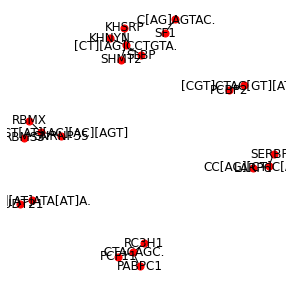

In [774]:
fig, ax = plt.subplots(figsize=(5,5))
nx.draw(G, with_labels=True, node_size=50, node_color="red")

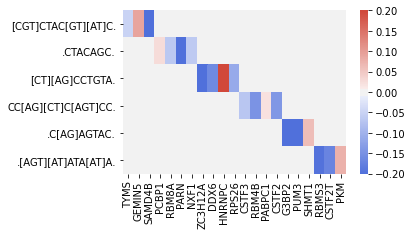

In [775]:
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(exp_decay_corr_df.T, vmin=-0.2, vmax=0.2, cmap=sns.diverging_palette(260, 15, as_cmap=True))
plt.savefig("results/motif_vs_RBP_saliency_network_corr_plot.pdf", width=5, height=3.5)

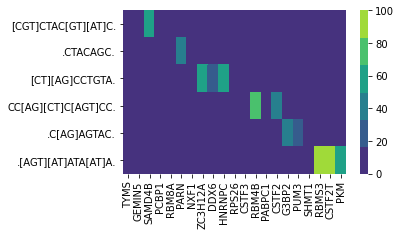

In [781]:
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(exp_decay_corp_df.T, vmin=0, vmax=100, cmap=sns.color_palette("viridis"))
plt.savefig("results/motif_vs_RBP_saliency_network_corpv_plot.pdf", width=5, height=3.5)